In [78]:
import pandas
import numpy
import pygsheets
import scipy.stats
import datetime

import matplotlib
import matplotlib.pyplot as mp
import seaborn

import textwrap

## colors

In [79]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
tracker_operating = sel_cmap(0.999)
tracker_construction = sel_cmap(0.8)
tracker_proposed = sel_cmap(0.6)
tracker_shelved = sel_cmap(0.4)
tracker_cancelled = sel_cmap(0.2)

## import terminals data from sheet

In [80]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1fNf3eK_nqgzXX6ijGlg9A4MPXAF4fh9ZmH3XnsrvS9A') # copy for 2022 report

#spreadsheet[1] "Gas Pipelines" tab is the second index
terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df(start='A2')

In [81]:
# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# remove oil export terminals
terms_df_orig = terms_df_orig.loc[terms_df_orig['Fuel']=='LNG']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig['Wiki']!='']
# remove N/A statuses
terms_df_orig = terms_df_orig.loc[terms_df_orig['Status']!='']

In [82]:
region_dict_df = spreadsheet.worksheet('title', 'Region dictionary').get_as_df()

In [83]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(terms_df_orig['Country'])))
region_list = sorted(list(set(terms_df_orig['Region'])))

## Asia resions versus AGT countries

In [93]:
asia_region_countries = region_dict_df.loc[region_dict_df.Region.isin(['South Asia', 'East Asia', 'SE Asia'])]['Country']
agt_countries = sorted(region_dict_df.loc[region_dict_df.AsiaGasTracker=='Yes']['Country'].tolist()+['Guam','Papua New Guinea'])

## table for exports

In [96]:
#mtpa by country
mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                   (terms_df_orig['Import/Export']=='Export')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                  (terms_df_orig['Import/Export']=='Export')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby('Region')['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in mtpa_by_region_df.index:
    mtpa_by_region_df.drop(index='Total', inplace=True)   
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

else:
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

# total
if 'Total' in mtpa_by_country_df.index:
    mtpa_by_country_df.drop(index='Total', inplace=True)   
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

else:
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

# save countries
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_export_df = mtpa_by_country_df.copy()
mtpa_by_country_df.to_excel('mtpa-by-country-export.xlsx')

mtpa_by_region_export_df = mtpa_by_region_df.copy()

mtpa_by_region_df

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_65544/3573645966.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtpa_by_region_df = mtpa_by_region_df.append(total)
/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_65544/3573645966.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtpa_by_country_df = mtpa_by_country_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,421.15,39.36,460.51,12.29,444.11,73.90,15.3,1.50,0.0
Eurasia,113.40,19.60,133.00,14.42,16.36,30.60,0.0,0.00,0.0
Sub-Saharan Africa,55.82,13.92,69.74,34.10,27.39,34.32,0.0,0.00,0.0
Middle East and North Africa,63.60,1.07,64.67,22.00,87.75,136.94,0.0,10.40,7.8
SE Asia,19.50,5.80,25.30,1.50,12.55,66.65,0.0,0.00,30.1
Australia and New Zealand,20.10,0.00,20.10,7.20,45.80,87.60,0.0,0.00,0.0
Latin America and the Caribbean,5.37,0.00,5.37,0.00,16.60,16.45,0.0,3.75,0.0
East Asia,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0
Europe,0.00,0.00,0.00,0.00,5.04,4.68,0.0,0.00,0.0
South Asia,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.0


## table for imports

In [97]:
#mtpa by country
mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                   (terms_df_orig['Import/Export']=='Import')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                  (terms_df_orig['Import/Export']=='Import')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby('Region')['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in mtpa_by_region_df.index:
    mtpa_by_region_df.drop(index='Total', inplace=True)   
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

else:
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

# total
if 'Total' in mtpa_by_country_df.index:
    mtpa_by_country_df.drop(index='Total', inplace=True)   
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

else:
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

# save countries
# drop all all-zero columns
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_import_df = mtpa_by_country_df.copy()
mtpa_by_country_df.to_excel('mtpa-by-country-import.xlsx')

mtpa_by_region_import_df = mtpa_by_region_df.copy()
mtpa_by_region_df

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_65544/1060818639.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtpa_by_region_df = mtpa_by_region_df.append(total)
/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_65544/1060818639.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtpa_by_country_df = mtpa_by_country_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,149.76,91.25,241.01,25.80,54.49,444.10,0.0,1.5,0.0
Europe,139.42,25.30,164.72,14.20,91.24,181.03,0.0,0.0,3.0
South Asia,69.71,33.00,102.71,8.38,80.95,65.20,0.0,0.0,0.0
SE Asia,76.84,21.66,98.50,8.40,28.34,45.05,0.0,0.0,0.0
Latin America and the Caribbean,43.48,12.28,55.76,6.46,16.07,53.36,0.0,0.0,0.0
Sub-Saharan Africa,6.88,1.70,8.58,0.50,7.70,0.11,0.0,0.0,0.0
Australia and New Zealand,3.30,1.90,5.20,0.00,1.75,0.00,0.0,0.0,0.0
Middle East and North Africa,5.15,0.00,5.15,11.10,18.64,48.90,11.8,0.0,0.0
North America,0.05,0.00,0.05,0.00,268.42,81.10,25.0,45.0,17.3
Eurasia,0.00,0.00,0.00,0.00,0.00,12.20,0.0,0.0,0.0


# Figure 4 - (new) plot of import/export for 2021, 2022, future

In [98]:
#shelved_2021_2022
shelved_export = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['Import/Export']=='Export')&
                                   (terms_df_orig.Status=='Shelved')&
                                   (terms_df_orig.ShelvedYear.isin([2021,2022]))]['CapacityInMtpa'].sum(min_count=0)

shelved_import = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['Import/Export']=='Import')&
                                   (terms_df_orig.Status=='Shelved')&
                                   (terms_df_orig.ShelvedYear.isin([2021,2022]))]['CapacityInMtpa'].sum(min_count=0)

#cancelled_2021_2022

cancelled_export = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['Import/Export']=='Export')&
                                   (terms_df_orig.Status=='Cancelled')&
                                   (terms_df_orig.CancelledYear.isin([2021,2022]))]['CapacityInMtpa'].sum(min_count=0)

cancelled_import = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['Import/Export']=='Import')&
                                   (terms_df_orig.Status=='Cancelled')&
                                   (terms_df_orig.CancelledYear.isin([2021,2022]))]['CapacityInMtpa'].sum(min_count=0)

#construction (present)
construction_export = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['Import/Export']=='Export')&
                                   (terms_df_orig.Status=='Construction')]['CapacityInMtpa'].sum(min_count=0)

construction_import = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['Import/Export']=='Import')&
                                   (terms_df_orig.Status=='Construction')]['CapacityInMtpa'].sum(min_count=0)

#proposed (present)
proposed_export = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['Import/Export']=='Export')&
                                   (terms_df_orig.Status=='Proposed')]['CapacityInMtpa'].sum(min_count=0)

proposed_import = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                   (terms_df_orig['Import/Export']=='Import')&
                                   (terms_df_orig.Status=='Proposed')]['CapacityInMtpa'].sum(min_count=0)

In [99]:
pandas.DataFrame(index=['Export','Import'],
                data={'Shelved':[shelved_export,shelved_import],
                      'Cancelled':[cancelled_export,cancelled_import],
                      'Construction (September 2022)':[construction_export,construction_import],
                      'Proposed (September 2022)':[proposed_export,proposed_import]})

,Shelved,Cancelled,Construction (September 2022),Proposed (September 2022)
Export,71.26,128.58,79.75,698.94
Import,28.78,94.83,187.09,494.59


In [100]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [101]:
adjust_lightness('#fee948', amount=1)

(0.9960784313725491, 0.9137254901960785, 0.28235294117647036)

# cost calculations

## create offshore and floating dfs

In [102]:
# insane outliers
# Ravenna - T068300
# Gorgon LNG (megaproject) - T068300
# Tanzania LNG Terminal trains 1, 2 - T026301, T026302
# Coral South FLNG Terminal - includes deep gas well construction - T025801
outlier_comboids = ['T068300','T068300','T026301','T026302','T025801']

In [103]:
terms_df_floating = terms_df_orig.loc[terms_df_orig.Floating=='yes']
terms_df_onshore = terms_df_orig.loc[terms_df_orig.Floating=='']

#terms_df_floating = terms_df_floating.loc[~terms_df_floating.ComboID.isin(outlier_comboids)]
#terms_df_onshore = terms_df_onshore.loc[~terms_df_onshore.ComboID.isin(outlier_comboids)]
terms_df_floating = terms_df_floating.loc[terms_df_floating.CostUSDPerMtpa<1e9]
terms_df_onshore = terms_df_onshore.loc[terms_df_onshore.CostUSDPerMtpa<1e9]

In [104]:
terms_df_floating_noexpansions = terms_df_floating.loc[~terms_df_floating['UnitName'].str.contains('Expansion')].drop_duplicates(subset=['TerminalName'], keep='first')
terms_df_onshore_noexpansions = terms_df_onshore.loc[~terms_df_onshore['UnitName'].str.contains('Expansion')].drop_duplicates(subset=['TerminalName'], keep='first')

## import

## export list

### make dataframe to use for terminal calculations

* regional averages for onshore terminals
  * fewer than 3 data points, then apply a global value rather than a regional one!
* global averages for offshore terminals

In [105]:
onshore_export_regional_costs = pandas.DataFrame(index=region_list)

onshore_export_regional_costs['NumberOfDataPoints'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].count()

onshore_export_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].mean()

onshore_export_regional_costs.loc[(onshore_export_regional_costs.NumberOfDataPoints<3) | 
                                  (onshore_export_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values[0]
print('export onshore')
onshore_export_regional_costs

export onshore


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,4.0,5.949954e+08
East Asia,NaN,5.892177e+08
Eurasia,1.0,5.892177e+08
Europe,NaN,5.892177e+08
Latin America and the Caribbean,3.0,5.239181e+08
Middle East and North Africa,6.0,5.447671e+08
North America,12.0,5.779734e+08
SE Asia,1.0,5.892177e+08
South Asia,NaN,5.892177e+08
Sub-Saharan Africa,5.0,6.235952e+08


In [106]:
onshore_import_regional_costs = pandas.DataFrame(index=region_list)

onshore_import_regional_costs['NumberOfDataPoints'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].count()

onshore_import_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].mean()

onshore_import_regional_costs.loc[(onshore_import_regional_costs.NumberOfDataPoints<3) | 
                                  (onshore_import_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values[0]
print('import onshore')
onshore_import_regional_costs

import onshore


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,1.0,2.696893e+08
East Asia,15.0,3.516386e+08
Eurasia,NaN,2.696893e+08
Europe,15.0,2.325106e+08
Latin America and the Caribbean,4.0,3.104855e+08
Middle East and North Africa,2.0,2.696893e+08
North America,2.0,2.696893e+08
SE Asia,9.0,2.049370e+08
South Asia,7.0,2.102106e+08
Sub-Saharan Africa,NaN,2.696893e+08


In [107]:
floating_export_regional_costs = pandas.DataFrame(index=region_list)

floating_export_regional_costs['NumberOfDataPoints'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].count()

floating_export_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].mean()

floating_export_regional_costs.loc[:,
                                #(floating_export_regional_costs.NumberOfDataPoints<3) | 
                                #  (floating_export_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values[0]
print('export floating')
floating_export_regional_costs

export floating


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,NaN,5.674729e+08
East Asia,NaN,5.674729e+08
Eurasia,1.0,5.674729e+08
Europe,NaN,5.674729e+08
Latin America and the Caribbean,NaN,5.674729e+08
Middle East and North Africa,NaN,5.674729e+08
North America,4.0,5.674729e+08
SE Asia,NaN,5.674729e+08
South Asia,NaN,5.674729e+08
Sub-Saharan Africa,4.0,5.674729e+08


In [108]:
floating_import_regional_costs = pandas.DataFrame(index=region_list)

floating_import_regional_costs['NumberOfDataPoints'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].count()

floating_import_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].mean()

floating_import_regional_costs.loc[:,
                                   #(floating_import_regional_costs.NumberOfDataPoints<3) | 
                                  #(floating_import_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values[0]
print('import floating')
floating_import_regional_costs

import floating


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,3.0,1.376477e+08
East Asia,NaN,1.376477e+08
Eurasia,NaN,1.376477e+08
Europe,14.0,1.376477e+08
Latin America and the Caribbean,3.0,1.376477e+08
Middle East and North Africa,NaN,1.376477e+08
North America,NaN,1.376477e+08
SE Asia,4.0,1.376477e+08
South Asia,8.0,1.376477e+08
Sub-Saharan Africa,2.0,1.376477e+08


### global calculations

In [109]:
cost_onshore_export = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values
cost_onshore_export_std = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].std().values

cost_floating_export = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values
cost_floating_export_error = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].std().values

cost_onshore_import = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values
cost_onshore_import_error = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].std().values

cost_floating_import = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values
cost_floating_import_error = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].std().values

In [110]:
cost_onshore_export

array([5.89217718e+08])

In [111]:
cost_floating_export

array([5.67472856e+08])

In [112]:
cost_onshore_import

array([2.69689349e+08])

In [113]:
cost_floating_import

array([1.3764766e+08])

### calculate how much export/import capacity data we have

In [114]:
terms_df_costs_exist = terms_df_orig.loc[~terms_df_orig.CostUSDPerMtpa.isnull()]
terms_df_costs_exist.to_excel('available-cost-data.xlsx', index=False)

In [115]:
#% of import terms that we have a capacity for?
print(terms_df_orig.loc[(terms_df_orig['Import/Export']=='Import')].shape)
print(terms_df_orig.loc[(terms_df_orig['Import/Export']=='Import')&
                  (~terms_df_orig['CapacityInMtpa'].isnull())].shape)
print(510/587 * 100)

(609, 76)
(516, 76)
86.88245315161839


In [116]:
#% of export terms that we have a capacity for?
print(terms_df_orig.loc[(terms_df_orig['Import/Export']=='Export')].shape)
print(terms_df_orig.loc[(terms_df_orig['Import/Export']=='Export')&
                  (~terms_df_orig['CapacityInMtpa'].isnull())].shape)
print(542/560 * 100)

(566, 76)
(548, 76)
96.78571428571429


In [117]:
floating_import_regional_costs.loc['Australia and New Zealand','RegionalCostUSDPerMtpa']

137647660.13235292

## now calculate the import terminal costs

In [118]:
terms_df_import = terms_df_orig.loc[terms_df_orig['Import/Export']=='Import'].reset_index(drop=True)

terms_df_import['CostUSDTotal'] = numpy.nan

# for import
for region in region_list:
    # for floating
    terms_df_import.loc[(terms_df_import['Floating']=='yes')&(terms_df_import['Region']==region),'CostUSDTotal'] = \
    terms_df_import.loc[(terms_df_import['Floating']=='yes')&(terms_df_import['Region']==region),'CapacityInMtpa'] * \
    floating_import_regional_costs.loc[region,'RegionalCostUSDPerMtpa']
    # for onshore
    terms_df_import.loc[(terms_df_import['Floating']!='yes')&(terms_df_import['Region']==region),'CostUSDTotal'] = \
    terms_df_import.loc[(terms_df_import['Floating']!='yes')&(terms_df_import['Region']==region),'CapacityInMtpa'] * \
    onshore_import_regional_costs.loc[region,'RegionalCostUSDPerMtpa']   

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_import['CostEstUSD'].isna()
terms_df_import.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_import[costs_exist_TF]['CostEstUSD']

## and calculate export terminal costs

In [119]:
terms_df_export = terms_df_orig.loc[terms_df_orig['Import/Export']=='Export'].reset_index(drop=True)

terms_df_export['CostUSDTotal'] = numpy.nan

# for import
for region in region_list:
    # for floating
    terms_df_export.loc[(terms_df_export['Floating']=='yes')&(terms_df_export['Region']==region),'CostUSDTotal'] = \
    terms_df_export.loc[(terms_df_export['Floating']=='yes')&(terms_df_export['Region']==region),'CapacityInMtpa'] * \
    floating_export_regional_costs.loc[region,'RegionalCostUSDPerMtpa']
    # for onshore
    terms_df_export.loc[(terms_df_export['Floating']!='yes')&(terms_df_export['Region']==region),'CostUSDTotal'] = \
    terms_df_export.loc[(terms_df_export['Floating']!='yes')&(terms_df_export['Region']==region),'CapacityInMtpa'] * \
    onshore_export_regional_costs.loc[region,'RegionalCostUSDPerMtpa']   

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_export['CostEstUSD'].isna()
terms_df_export.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_export[costs_exist_TF]['CostEstUSD']

## import terminal costs table

In [120]:
#mtpa by country
cost_by_country_import_df = pandas.DataFrame(columns=status_list, index=country_list)
cost_by_region_import_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    cost_by_country_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby('Country')['CostUSDTotal'].sum()

for status in status_list:
    #print(status)
    cost_by_region_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby('Region')['CostUSDTotal'].sum()

cost_by_country_import_df = cost_by_country_import_df.fillna(0)
cost_by_region_import_df = cost_by_region_import_df.fillna(0)

# add total and proposed+construction info
cost_by_region_import_df['Proposed+Construction'] = cost_by_region_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_import_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_region_import_df = cost_by_region_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_region_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_import_df['Proposed+Construction'] = cost_by_country_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_import_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_country_import_df = cost_by_country_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_country_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in cost_by_region_import_df.index:
    cost_by_region_import_df.drop(index='Total', inplace=True)   
    total = cost_by_region_import_df.sum(axis=0)
    total.name='Total'
    cost_by_region_import_df = cost_by_region_import_df.append(total)

else:
    total = cost_by_region_import_df.sum(axis=0)
    total.name='Total'
    cost_by_region_import_df = cost_by_region_import_df.append(total)

# total
if 'Total' in cost_by_country_import_df.index:
    cost_by_country_import_df.drop(index='Total', inplace=True)   
    total = cost_by_country_import_df.sum(axis=0)
    total.name='Total'
    cost_by_country_import_df = cost_by_country_import_df.append(total)

else:
    total = cost_by_country_import_df.sum(axis=0)
    total.name='Total'
    cost_by_country_import_df = cost_by_country_import_df.append(total)

# save countries
cost_by_country_import_df = cost_by_country_import_df.loc[~(cost_by_country_import_df==0).all(axis=1)]
cost_by_country_import_df.to_excel('cost-by-country-import.xlsx')

cost_by_region_import_df/1e9

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_65544/2623154238.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_by_region_import_df = cost_by_region_import_df.append(total)
/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_65544/2623154238.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_by_country_import_df = cost_by_country_import_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,49.999150,31.296423,81.295573,7.144935,18.518813,154.534518,0.000000,0.527458,0.000000
Europe,26.259428,3.219384,29.478813,3.129799,18.624343,40.037091,0.000000,0.000000,0.412943
SE Asia,18.671186,2.830531,21.501717,2.907518,7.538848,7.248716,0.000000,0.000000,0.000000
South Asia,10.863513,5.719267,16.582780,1.774543,13.700529,12.314252,0.000000,0.000000,0.000000
Latin America and the Caribbean,4.636187,1.690313,6.326500,0.889204,4.384569,8.812590,0.000000,0.000000,0.000000
Middle East and North Africa,4.500000,0.000000,4.500000,1.527889,5.027009,8.571677,1.624242,0.000000,0.000000
Sub-Saharan Africa,3.177601,0.350000,3.527601,0.068824,1.059887,0.015141,0.000000,0.000000,0.000000
Australia and New Zealand,0.716910,0.172500,0.889410,0.000000,0.172500,0.000000,0.000000,0.000000,0.000000
North America,0.013484,0.000000,0.013484,0.000000,64.828924,20.459890,6.346109,12.136021,4.665626
Eurasia,0.000000,0.000000,0.000000,0.000000,0.000000,2.933697,0.000000,0.000000,0.000000


## export terminal costs table

In [121]:
#mtpa by country
cost_by_country_export_df = pandas.DataFrame(columns=status_list, index=country_list)
cost_by_region_export_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    cost_by_country_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby('Country')['CostUSDTotal'].sum()

for status in status_list:
    #print(status)
    cost_by_region_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby('Region')['CostUSDTotal'].sum()

cost_by_country_export_df = cost_by_country_export_df.fillna(0)
cost_by_region_export_df = cost_by_region_export_df.fillna(0)

# add total and proposed+construction info
cost_by_region_export_df['Proposed+Construction'] = cost_by_region_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_export_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_region_export_df = cost_by_region_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_region_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_export_df['Proposed+Construction'] = cost_by_country_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_export_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_country_export_df = cost_by_country_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_country_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in cost_by_region_export_df.index:
    cost_by_region_export_df.drop(index='Total', inplace=True)   
    total = cost_by_region_export_df.sum(axis=0)
    total.name='Total'
    cost_by_region_export_df = cost_by_region_export_df.append(total)

else:
    total = cost_by_region_export_df.sum(axis=0)
    total.name='Total'
    cost_by_region_export_df = cost_by_region_export_df.append(total)

# total
if 'Total' in cost_by_country_export_df.index:
    cost_by_country_export_df.drop(index='Total', inplace=True)   
    total = cost_by_country_export_df.sum(axis=0)
    total.name='Total'
    cost_by_country_export_df = cost_by_country_export_df.append(total)

else:
    total = cost_by_country_export_df.sum(axis=0)
    total.name='Total'
    cost_by_country_export_df = cost_by_country_export_df.append(total)

# save countries
cost_by_country_export_df = cost_by_country_export_df.loc[~(cost_by_country_export_df==0).all(axis=1)]
cost_by_country_export_df.to_excel('cost-by-country-export.xlsx')

cost_by_region_export_df/1e9

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_65544/1869466848.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_by_region_export_df = cost_by_region_export_df.append(total)
/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_65544/1869466848.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_by_country_export_df = cost_by_country_export_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,291.079718,30.201867,321.281585,11.164123,255.674029,42.712233,8.842993,0.866960,0.000000
Eurasia,71.044626,19.100000,90.144626,14.918846,11.678511,18.030062,0.000000,0.000000,0.000000
Sub-Saharan Africa,73.680642,15.001305,88.681947,24.680967,17.401679,26.993814,0.000000,0.000000,0.000000
Middle East and North Africa,54.317129,0.582901,54.900029,11.984877,58.593035,68.074428,0.000000,5.665578,4.249184
SE Asia,36.551966,2.378435,38.930402,0.883827,12.031095,55.565653,0.000000,0.000000,17.735453
Australia and New Zealand,28.301483,0.000000,28.301483,17.250000,30.920755,176.846423,0.000000,0.000000,0.000000
Latin America and the Caribbean,10.000000,0.000000,10.000000,0.000000,8.740743,6.481188,0.000000,0.974175,0.000000
East Asia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Europe,0.000000,0.000000,0.000000,0.000000,6.000000,6.182825,0.000000,0.000000,0.000000
South Asia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## costs of CWD/our version projects projects

In [122]:
terms_df_import.loc[terms_df_import.Construction_Sanctioned_July_2022=='yes']['CostUSDTotal'].sum()/1e9

0.0

In [123]:
terms_df_export.loc[terms_df_export.Construction_Sanctioned_July_2022=='yes']['CostUSDTotal'].sum()/1e9

141.9224027493161

In [124]:
terms_df_export.loc[terms_df_export.Construction_Sanctioned_July_2022=='yes'][['TerminalName','UnitName','CapacityInMtpa','Wiki','Import/Export','CostEstUSD','CostUSDTotal']]

,TerminalName,UnitName,CapacityInMtpa,Wiki,Import/Export,CostEstUSD,CostUSDTotal
26,Calcasieu Pass LNG Terminal,T13,0.67,https://www.gem.wiki/Calcasieu_Pass_LNG_Terminal,Export,NaN,3.872422e+08
27,Calcasieu Pass LNG Terminal,T14,0.67,https://www.gem.wiki/Calcasieu_Pass_LNG_Terminal,Export,NaN,3.872422e+08
28,Calcasieu Pass LNG Terminal,T15,0.67,https://www.gem.wiki/Calcasieu_Pass_LNG_Terminal,Export,NaN,3.872422e+08
29,Calcasieu Pass LNG Terminal,T16,0.67,https://www.gem.wiki/Calcasieu_Pass_LNG_Terminal,Export,NaN,3.872422e+08
30,Calcasieu Pass LNG Terminal,T17,0.67,https://www.gem.wiki/Calcasieu_Pass_LNG_Terminal,Export,NaN,3.872422e+08
31,Calcasieu Pass LNG Terminal,T18,0.67,https://www.gem.wiki/Calcasieu_Pass_LNG_Terminal,Export,NaN,3.872422e+08
94,Golden Pass LNG Terminal,T1,6.03,https://www.gem.wiki/Golden_Pass_LNG,Export,3.333333e+09,3.333333e+09
95,Golden Pass LNG Terminal,T2,6.03,https://www.gem.wiki/Golden_Pass_LNG,Export,3.333333e+09,3.333333e+09
96,Golden Pass LNG Terminal,T3,6.03,https://www.gem.wiki/Golden_Pass_LNG,Export,3.333333e+09,3.333333e+09
142,Plaquemines LNG Terminal,Phase 1 (Trains 1–18),13.33,https://www.gem.wiki/Venture_Global_Plaquemine...,Export,1.320000e+10,1.320000e+10


# pie charts with costs, mtpa

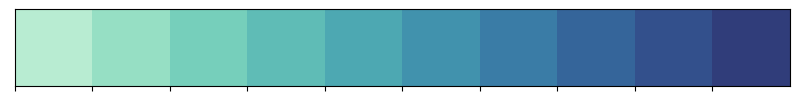

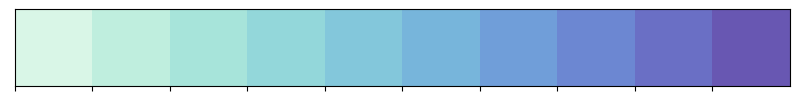

In [125]:
# mess with some color pallettes
#seaborn.color_palette('husl', 10)
# seaborn.palplot(seaborn.husl_palette(10, h=0.05, s=0.9, l=0.65))
# seaborn.palplot(seaborn.husl_palette(10, h=0.05, l=0.55))

seaborn.palplot(seaborn.cubehelix_palette(10, start=0.5, rot=-.5, gamma=1.5, hue=1.25, light=0.9, dark=0.4))
seaborn.palplot(seaborn.cubehelix_palette(10, start=0.5, rot=-.5, gamma=.75, hue=1.25, light=0.9, dark=0.3))

cmap_light = seaborn.cubehelix_palette(10, start=0.5, rot=-.5, gamma=0.75, hue=1.25, light=0.9, dark=0.3, as_cmap=True)
cmap_dark = seaborn.cubehelix_palette(10, start=0.5, rot=-.5, gamma=1.5, hue=1.25, light=0.9, dark=0.4, as_cmap=True)

In [126]:
seaborn.color_palette("BuPu", 10, desat=0.5)
seaborn.color_palette("YlOrBr", 10, desat=0.5)

[(0.9455055747789312, 0.9341868512110726, 0.8365167243367935),
 (0.9143291041906959, 0.8821337946943483, 0.7464628988850442),
 (0.8785582468281432, 0.8156055363321799, 0.6435178777393309),
 (0.8298385236447521, 0.7211188004613611, 0.49735870818915795),
 (0.8006958861976162, 0.6330757400999616, 0.40993079584775105),
 (0.7607266435986159, 0.5464167627835448, 0.3409573241061131),
 (0.7045213379469435, 0.46073817762399083, 0.28325259515570944),
 (0.6203690888119955, 0.37068050749711656, 0.2197693194925029),
 (0.5195232602845059, 0.2980238369857747, 0.18131487889273357),
 (0.4127028066128412, 0.234317570165321, 0.14948096885813145)]

### mtpa_by_region_import_df

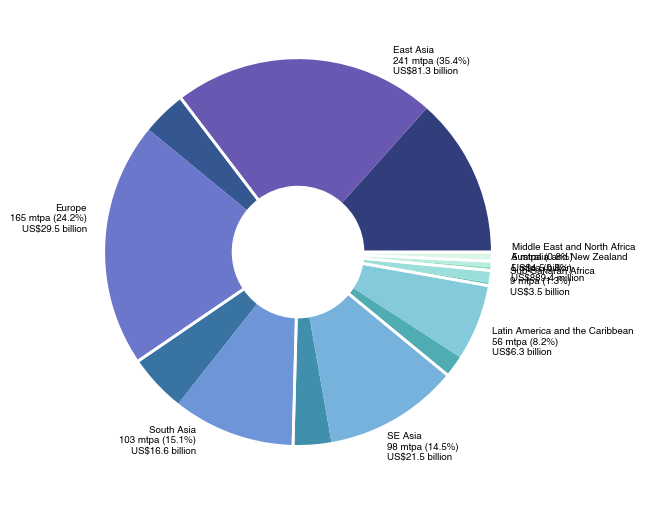

In [127]:
font_size=7

fig = mp.figure(figsize=(6.5,6.5))
ax = fig.add_subplot(111)

nwedges = 8 # 8 nonzero rows #region_list.__len__()
region_order = mtpa_by_region_import_df.index[:nwedges]
pie_vals = mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].values

pie_labels = mtpa_by_region_import_df.index
pie_labels_mtpa = mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,0)):,} mtpa')
pie_labels_perc = (mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'] / 
                   mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f' ({x:.1f}%)')
pie_labels_cost = cost_by_region_import_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\nUS${x/1e9:.1f} billion' if x>1e9 else f'\nUS${x/1e6:.1f} million')

# ****************************************
pie_vals_separated = mtpa_by_region_import_df.loc[region_order][['Construction','Proposed']].values.flatten()

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(1,0,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(1,0,nwedges))

pie_labels = [i+j+k+l for i,j,k,l in zip(pie_labels, pie_labels_mtpa, pie_labels_perc, pie_labels_cost)]
pie_width = 0.666

# ****************************************
# size=0.3
ax.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_dark_10, cmap_light_10)).reshape(2*nwedges,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=2, width=pie_width),
       textprops={'fontsize': font_size})


ax.tick_params(labelsize=font_size)

fig.tight_layout()

# big ole panel figure - not-cleaned-up version of Figure 2

In [128]:
cool_light = seaborn.color_palette("viridis", 4, desat=1)[:3]
cool_dark = seaborn.color_palette("viridis", 4, desat=0.5)[:3]
warm_light = seaborn.color_palette("OrRd", 8, desat=1)[3:]
warm_dark = seaborn.color_palette("OrRd", 8, desat=0.5)[3:]

cool_light.insert(1,warm_light[0])
colors_light = cool_light+warm_light[1:]

cool_dark.insert(1,warm_dark[0])
colors_dark = cool_dark+warm_dark[1:]

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_65544/1234118700.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(region_order, ha='right', va='top')


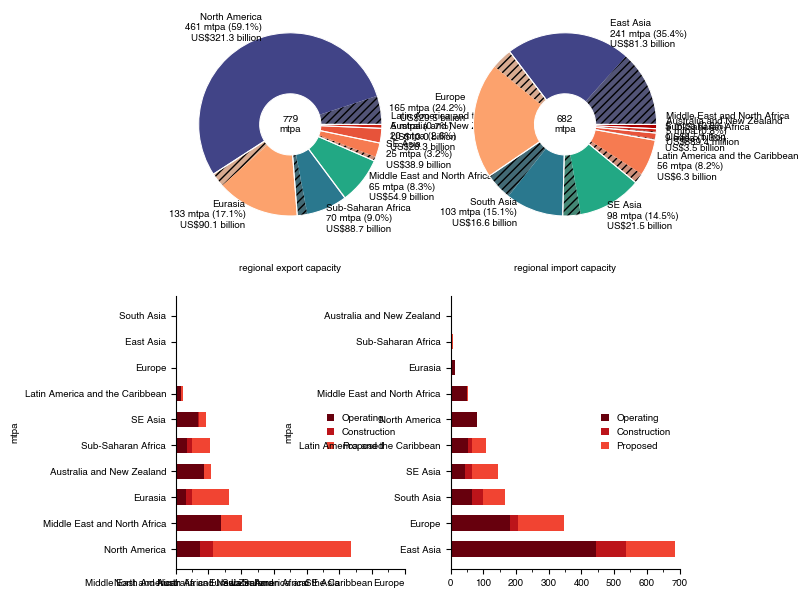

In [129]:
font_size=7
ytop = 700
set_width=0.6
pie_chart_line_width=0.75

fig = mp.figure(figsize=(6.5,8))#, constrained_layout=True)
widths = [1,1]
heights = [1.25,1]
gs = matplotlib.gridspec.GridSpec(nrows=2, ncols=2, figure=fig,
                                 wspace=0.2, hspace=0,
                                 width_ratios=widths,
                                 height_ratios=heights)

################################################################## TOP LEFT
ax1 = fig.add_subplot(gs[0,0])

nwedges = 7 # 8 nonzero rows #region_list.__len__()
region_order = mtpa_by_region_export_df.index[:nwedges]

pie_vals = mtpa_by_region_export_df.loc[region_order]['Proposed+Construction'].values
pie_labels = mtpa_by_region_export_df.index
pie_labels_mtpa = mtpa_by_region_export_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,0)):,} mtpa')
pie_labels_perc = (mtpa_by_region_export_df.loc[region_order]['Proposed+Construction'] / 
                   mtpa_by_region_export_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f' ({x:.1f}%)')
pie_labels_cost = cost_by_region_export_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\nUS${x/1e9:.1f} billion' if x>1e9 else f'\nUS${x/1e6:.1f} million')

# ****************************************
pie_vals_separated = mtpa_by_region_export_df.loc[region_order][['Construction','Proposed']].values.flatten()

#nwedges_separated = 20
cmap_light = colors_light[:nwedges]#cmap_light(numpy.linspace(1,0,nwedges))
cmap_dark = colors_dark[:nwedges]#cmap_dark(numpy.linspace(1,0,nwedges))

pie_labels = [i+j+k+l for i,j,k,l in zip(pie_labels, pie_labels_mtpa, pie_labels_perc, pie_labels_cost)]
pie_width = 0.666

# ****************************************
# CHANGING THIS PART!!!!!!!!!!!!!!! FOR ASIA LNG REPORT
# ****************************************
# size=0.3
pie1 = ax1.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_dark, cmap_light)).reshape(2*nwedges,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax1.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,#cmap(numpy.linspace(0,1,pie_vals.size))[::-1],
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=pie_chart_line_width, width=pie_width),
       textprops={'fontsize': font_size})

hatch_list = ['////','']*8
for i in range(pie1[0].__len__()):
    pie1[0][i].set(hatch=hatch_list[i])

################################################################## TOP RIGHT
ax2 = fig.add_subplot(gs[0,1])

nwedges = 8 # 8 nonzero rows #region_list.__len__()
region_order = mtpa_by_region_import_df.index[:nwedges]
pie_vals = mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].values

pie_labels = mtpa_by_region_import_df.index
pie_labels_mtpa = mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,0)):,} mtpa')
pie_labels_perc = (mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'] / 
                   mtpa_by_region_import_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f' ({x:.1f}%)')
pie_labels_cost = cost_by_region_import_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\nUS${x/1e9:.1f} billion' if x>1e9 else f'\nUS${x/1e6:.1f} million')

# ****************************************
pie_vals_separated = mtpa_by_region_import_df.loc[region_order][['Construction','Proposed']].values.flatten()

nwedges_separated = 20
cmap_light = colors_light[:nwedges]#cmap_light(numpy.linspace(1,0,nwedges))
cmap_dark = colors_dark[:nwedges]#cmap_dark(numpy.linspace(1,0,nwedges))

pie_labels = [i+j+k+l for i,j,k,l in zip(pie_labels, pie_labels_mtpa, pie_labels_perc, pie_labels_cost)]
pie_width = 0.666

# ****************************************
# size=0.3
pie2 = ax2.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_dark, cmap_light)).reshape(2*nwedges,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax2.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=pie_chart_line_width, width=pie_width),
       textprops={'fontsize': font_size})

hatch_list = ['////','']*8
for i in range(pie2[0].__len__()):
    pie2[0][i].set(hatch=hatch_list[i])

################################################################## LOWER LEFT
region_order = mtpa_by_region_export_df[['Operating','Construction','Proposed']].sum(axis=1).sort_values(ascending=False).index[1:]
use_this_df = mtpa_by_region_export_df.loc[region_order,:]

# ****************************************
# CHANGING THIS PART!!!!!!!!!!!!!!! FOR ASIA LNG REPORT
# ****************************************
ax3 = fig.add_subplot(gs[1,0])

ax3.barh(use_this_df.index, use_this_df['Operating'],
       color=tracker_operating, label='Operating', height=set_width)
ax3.barh(use_this_df.index, use_this_df['Construction'],
       color=tracker_construction, label='Construction',
      left=use_this_df['Operating'], height=set_width)
ax3.barh(use_this_df.index, use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      left=use_this_df[['Operating','Construction']].sum(axis=1), height=set_width)

ax3_l,ax3_h = ax3.get_legend_handles_labels()
ax3.legend(ax3_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=5)

ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.tick_params(labelsize=font_size)
ax3.set_xticklabels(region_order, ha='right', va='top')
ax3.set_ylabel('mtpa', size=font_size)

ax3.set_xlim(0, ytop)
ax3.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

################################################################## LOWER RIGHT
region_order = mtpa_by_region_import_df[['Operating','Construction','Proposed']].sum(axis=1).sort_values(ascending=False).index[1:]
use_this_df = mtpa_by_region_import_df.loc[region_order,:]

ax4 = fig.add_subplot(gs[1,1])

ax4.barh(use_this_df.index, use_this_df['Operating'],
       color=tracker_operating, label='Operating', height=set_width)
ax4.barh(use_this_df.index, use_this_df['Construction'],
       color=tracker_construction, label='Construction',
      left=use_this_df['Operating'], height=set_width)
ax4.barh(use_this_df.index, use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      left=use_this_df[['Operating','Construction']].sum(axis=1), height=set_width)

ax4_l,ax4_h = ax4.get_legend_handles_labels()
ax4.legend(ax4_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=5)

ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.tick_params(labelsize=font_size)
#ax4.set_xticklabels(region_order, ha='right', va='top')
#ax.set_xlabel('start year', size=font_size)
ax4.set_ylabel('mtpa', size=font_size)

ax4.set_xlim(0, ytop)
ax4.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

ax1.tick_params(labelsize=font_size)
ax2.tick_params(labelsize=font_size)
ax3.tick_params(labelsize=font_size)
ax4.tick_params(labelsize=font_size)

ax1_pie_total_mtpa = '{:.0f}'.format(mtpa_by_region_export_df.loc['Total','Proposed+Construction'])+'\nmtpa'
ax2_pie_total_mtpa = '{:.0f}'.format(mtpa_by_region_import_df.loc['Total','Proposed+Construction'])+'\nmtpa'

ax1.text(x=0,y=0,s=ax1_pie_total_mtpa,size=font_size,
        va='center',
        ha='center')
ax2.text(x=0,y=0,s=ax2_pie_total_mtpa,size=font_size,
        va='center',
        ha='center')

ax3.text(x=0.5, y=1.1, s='regional export capacity',
         ha='center', va='center',
         size=font_size, transform=ax3.transAxes)
ax4.text(x=0.5, y=1.1, s='regional import capacity', 
         ha='center', va='center',
         size=font_size, transform=ax4.transAxes)

#fig.tight_layout()
mp.savefig('saved-figures/pie-graph-for-asia-lng-report.pdf', bbox_inches='tight')

# separate out the horizontal bar plot

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_65544/2384064080.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax4.yaxis.set_ticklabels(region_names_wrapped, ha='right', va='center')


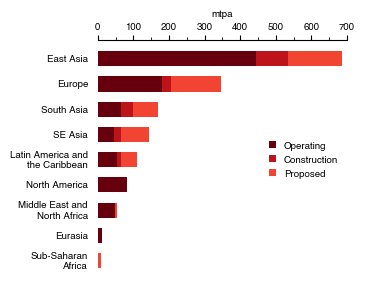

In [130]:
font_size=7
ytop = 700
set_width=0.6
pie_chart_line_width=0.75

fig = mp.figure(figsize=(3.75,3))#, constrained_layout=True)
widths = [1]
heights = [1]
gs = matplotlib.gridspec.GridSpec(nrows=1, ncols=1, figure=fig,
                                 #wspace=0.2, hspace=0,
                                 width_ratios=widths,
                                 height_ratios=heights)

################################################################## LOWER LEFT

# ****************************************
# CHANGING THIS PART!!!!!!!!!!!!!!! FOR ASIA LNG REPORT
# ****************************************

################################################################## LOWER RIGHT
region_order = mtpa_by_region_import_df[['Operating','Construction','Proposed']].sum(axis=1).drop('Total').sort_values().index[1:]
use_this_df = mtpa_by_region_import_df.loc[region_order,:]

region_names_wrapped = [textwrap.fill(i, 17) for i in region_order]

ax4 = fig.add_subplot(gs[0,0])

ax4.barh(use_this_df.index, use_this_df['Operating'],
       color=tracker_operating, label='Operating', height=set_width)
ax4.barh(use_this_df.index, use_this_df['Construction'],
       color=tracker_construction, label='Construction',
      left=use_this_df['Operating'], height=set_width)
ax4.barh(use_this_df.index, use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      left=use_this_df[['Operating','Construction']].sum(axis=1), height=set_width)

ax4_l,ax4_h = ax4.get_legend_handles_labels()
ax4.legend(ax4_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=5)

ax4.spines['right'].set_visible(False)
#ax4.spines['top'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax4.spines['bottom'].set_visible(False)
ax4.set_xlabel('mtpa', size=font_size)
ax4.tick_params(labelsize=font_size, left=False)
ax4.xaxis.set_label_position('top')
ax4.xaxis.set_ticks_position('top')

ax4.yaxis.set_ticklabels(region_names_wrapped, ha='right', va='center')

ax4.set_xlim(0, ytop)
ax4.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

ax4.tick_params(labelsize=font_size)

fig.tight_layout()
mp.savefig('saved-figures/pie-graph-for-asia-lng-report-bars-only.pdf', bbox_inches='tight')

# top 10 countries developing terminals rn

In [131]:
mtpa_by_country_total_df = mtpa_by_country_export_df.add(mtpa_by_country_import_df, fill_value=0)
mtpa_by_country_total_df = mtpa_by_country_total_df.loc[mtpa_by_country_total_df.index.isin(
    region_dict_df.loc[region_dict_df.AsiaGasTracker=='Yes']['Country'].tolist())].sort_values('Proposed+Construction', ascending=False)

cost_by_country_total_df = cost_by_country_export_df.add(cost_by_country_import_df, fill_value=0)/1e9

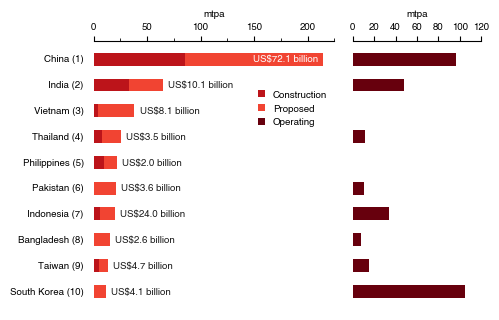

In [132]:
font_size=7
xtop1 = 225
xtop2 = 120
set_width=0.5

n_countries = 10
use_this_df = mtpa_by_country_total_df.copy().sort_values('Proposed+Construction', ascending=True)[-n_countries:]

yaxis_labels = [use_this_df.index.tolist()[i] + ' ('+str(10-i)+')' for i in range(n_countries)]

use_this_df_costs = cost_by_country_total_df.copy()
capex_text = ['US$'+str('{0:.1f}'.format(use_this_df_costs.loc[i]['Proposed+Construction']))+' billion' 
              for i in use_this_df.index]

fig = mp.figure(figsize=(5,3.5))#, constrained_layout=True)
widths = [1,xtop2/xtop1]
heights = [1]
gs = matplotlib.gridspec.GridSpec(nrows=1, ncols=2, figure=fig,
                                 wspace=0.1, hspace=0,
                                 width_ratios=widths,
                                 height_ratios=heights)

# proposed+construction
ax1 = fig.add_subplot(gs[0,0])

ax1.barh(y=range(n_countries),
         width=use_this_df['Construction'],
         color=tracker_construction,
         label='Construction',
         height=set_width)
ax1.barh(y=range(n_countries),
         width=use_this_df['Proposed'],
         left=use_this_df['Construction'],
         color=tracker_proposed,
         label='Proposed',
         height=set_width)

ax1.spines['right'].set_visible(False)
#ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labelsize=font_size,
               left=False)
ax1.set_xlabel('mtpa', size=font_size)
ax1.xaxis.set_label_position('top')
ax1.xaxis.set_ticks_position('top')
ax1.yaxis.set_ticks(range(n_countries))
ax1.yaxis.set_ticklabels(yaxis_labels, ha='right', va='center')
ax1.set_xlim(0, xtop1)
ax1.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

for i in range(n_countries):
    if use_this_df.index[i]=='China':
        ax1.text(s=capex_text[i],
                 x=use_this_df[['Proposed','Construction']].sum(axis=1).values[i]-5,
                 y=range(n_countries)[i],
                 fontsize=font_size,
                 color='1',
                 ha='right', va='center')
    else:
        ax1.text(s=capex_text[i],
                 x=use_this_df[['Proposed','Construction']].sum(axis=1).values[i]+5,
                 y=range(n_countries)[i],
                 fontsize=font_size,
                 color='0.1',
                 ha='left', va='center')

# operating
ax2 = fig.add_subplot(gs[0,1])

ax2.barh(y=range(n_countries),
         width=use_this_df['Operating'],
         color=tracker_operating,
         label='Operating',
         height=set_width)

ax2.spines['right'].set_visible(False)
#ax1.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.tick_params(labelsize=font_size,
               left=False)
ax2.set_xlabel('mtpa', size=font_size)
ax2.xaxis.set_label_position('top')
ax2.xaxis.set_ticks_position('top')
ax2.yaxis.set_ticks([])
#ax2.yaxis.set_ticklabels(use_this_df.index.tolist(), ha='right', va='center')
ax2.set_xlim(0, xtop2)
ax2.set_xticks([0,20,40,60,80,100,120])
#ax2.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

# combine legends
ax1_h,ax1_l = ax1.get_legend_handles_labels()
ax2_h,ax2_l = ax2.get_legend_handles_labels()
ax1.legend(ax1_h+ax2_h, ax1_l+ax2_l, 
           fontsize=font_size, frameon=False, handlelength=0.75, loc=(0.666,0.666))

#fig.tight_layout()

mp.savefig('saved-figures/panel-bar-plots-top10-with-costs.png', bbox_inches='tight', 
           dpi=600, transparent=True)
mp.savefig('saved-figures/panel-bar-plots-top10-with-costs.svg', bbox_inches='tight', 
           transparent=True)
mp.savefig('saved-figures/panel-bar-plots-top10-with-costs.pdf', bbox_inches='tight', 
           transparent=True)


# operating to left now

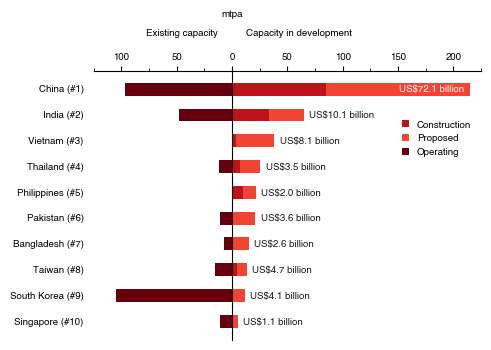

In [133]:
font_size=7
xtop1 = 225
xtop2 = 125
set_width=0.5

n_countries = 10
use_this_df = mtpa_by_country_import_df.copy().loc[mtpa_by_country_import_df.index.isin(
    region_dict_df.loc[region_dict_df.AsiaGasTracker=='Yes']['Country'].tolist())
                                                  ].sort_values('Proposed+Construction', ascending=True)[-n_countries:]

yaxis_labels = [use_this_df.index.tolist()[i] + ' (#'+str(10-i)+')' for i in range(n_countries)]

use_this_df_costs = cost_by_country_import_df.copy()/1e9
capex_text = ['US$'+str('{0:.1f}'.format(use_this_df_costs.loc[i]['Proposed+Construction']))+' billion' 
              for i in use_this_df.index]

fig = mp.figure(figsize=(5,3.5))#, constrained_layout=True)
widths = [1,xtop1/xtop2]
heights = [1]
gs = matplotlib.gridspec.GridSpec(nrows=1, ncols=2, figure=fig,
                                 wspace=0., hspace=0,
                                 width_ratios=widths,
                                 height_ratios=heights)

# proposed+construction
ax1 = fig.add_subplot(gs[0,1])

ax1.barh(y=range(n_countries),
         width=use_this_df['Construction'],
         color=tracker_construction,
         label='Construction',
         height=set_width)
ax1.barh(y=range(n_countries),
         width=use_this_df['Proposed'],
         left=use_this_df['Construction'],
         color=tracker_proposed,
         label='Proposed',
         height=set_width)

ax1.spines['right'].set_visible(False)
#ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labelsize=font_size,
               left=False)
#ax1.set_xlabel('mtpa', size=font_size)
ax1.xaxis.set_label_position('top')
ax1.xaxis.set_ticks_position('top')
ax1.yaxis.set_ticks([])
#ax2.yaxis.set_ticklabels(use_this_df.index.tolist(), ha='right', va='center')
ax1.set_xlim(0, xtop1)
#ax1.set_xticks([0,20,40,60,80,100,120])
ax1.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

for i in range(n_countries):
    if use_this_df.index[i]=='China':
        ax1.text(s=capex_text[i],
                 x=use_this_df[['Proposed','Construction']].sum(axis=1).values[i]-5,
                 y=range(n_countries)[i],
                 fontsize=font_size,
                 color='1',
                 ha='right', va='center')
    else:
        ax1.text(s=capex_text[i],
                 x=use_this_df[['Proposed','Construction']].sum(axis=1).values[i]+5,
                 y=range(n_countries)[i],
                 fontsize=font_size,
                 color='0.1',
                 ha='left', va='center')

# operating
ax2 = fig.add_subplot(gs[0,0])

ax2.barh(y=range(n_countries),
         width=use_this_df['Operating'],
         color=tracker_operating,
         label='Operating',
         height=set_width)

#ax2.spines['right'].set_visible(False)
#ax1.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.tick_params(labelsize=font_size,
               left=False)
#ax2.set_xlabel('mtpa', size=font_size)
ax2.xaxis.set_label_position('top')
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_ticks([50,100,150])
ax2.yaxis.set_ticks(range(n_countries))
ax2.yaxis.set_ticklabels(yaxis_labels, ha='right', va='center')
ax2.set_xlim(xtop2,0)
ax2.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
#ax2.yaxis.set_tick_params(pad=-30)

# combine legends
ax1_h,ax1_l = ax1.get_legend_handles_labels()
ax2_h,ax2_l = ax2.get_legend_handles_labels()
ax1.legend(ax1_h+ax2_h, ax1_l+ax2_l, 
           fontsize=font_size, frameon=False, handlelength=0.75, loc=(0.666,0.666))

ax1.text(s='mtpa',
         y=11.75,
         x=0,
         #transform=ax1.transAxes,
         fontsize=font_size,
         ha='center', va='bottom')

ax2.text(s='Existing capacity',
         y=11,
         x=12.5,
         #transform=ax2.transAxes,
         fontsize=font_size,
         ha='right', va='bottom')

ax1.text(s='Capacity in development',
         y=11,
         x=12.5,
         #transform=ax1.transAxes,
         fontsize=font_size,
         ha='left', va='bottom')

#fig.tight_layout()

mp.savefig('saved-figures/panel-bar-plots-top10-with-costs-bidirectional-bar.png', bbox_inches='tight', 
           dpi=600, transparent=True)
mp.savefig('saved-figures/panel-bar-plots-top10-with-costs-bidirectional-bar.svg', bbox_inches='tight', 
           transparent=True)
mp.savefig('saved-figures/panel-bar-plots-top10-with-costs-bidirectional-bar.pdf', bbox_inches='tight', 
           transparent=True)


# alternative figure with combined bars

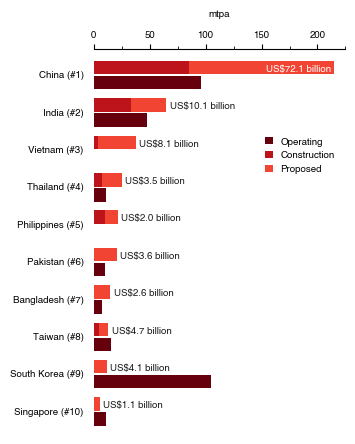

In [134]:
font_size=7
spread_out=2.5
xtop1 = 225
set_width=0.9

n_countries = 10
use_this_df = mtpa_by_country_import_df.copy().loc[mtpa_by_country_import_df.index.isin(
    region_dict_df.loc[region_dict_df.AsiaGasTracker=='Yes']['Country'].tolist())
                                                  ].sort_values('Proposed+Construction', ascending=True)[-n_countries:]

yaxis_labels = [use_this_df.index.tolist()[i] + ' (#'+str(10-i)+')' for i in range(n_countries)]

use_this_df_costs = cost_by_country_import_df.copy()/1e9
capex_text = ['US$'+str('{0:.1f}'.format(use_this_df_costs.loc[i]['Proposed+Construction']))+' billion' 
              for i in use_this_df.index]

fig = mp.figure(figsize=(3.25,5))#, constrained_layout=True)
widths = [1]
heights = [1]
gs = matplotlib.gridspec.GridSpec(nrows=1, ncols=1, figure=fig,
                                 wspace=0., hspace=0,
                                 width_ratios=widths,
                                 height_ratios=heights)

# proposed+construction
ax1 = fig.add_subplot(gs[0,0])

ax1.barh(y=numpy.arange(n_countries)*spread_out,
         width=use_this_df['Operating'],
         color=tracker_operating,
         label='Operating',
         height=set_width)

ax1.barh(y=numpy.arange(n_countries)*spread_out+1,
         width=use_this_df['Construction'],
         color=tracker_construction,
         label='Construction',
         height=set_width)

ax1.barh(y=numpy.arange(n_countries)*spread_out+1,
         width=use_this_df['Proposed'],
         left=use_this_df['Construction'],
         color=tracker_proposed,
         label='Proposed',
         height=set_width)

ax1.spines['right'].set_visible(False)
#ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labelsize=font_size,
               left=False)
#ax1.set_xlabel('mtpa', size=font_size)
ax1.xaxis.set_label_position('top')
ax1.xaxis.set_ticks_position('top')
ax1.yaxis.set_ticks([])
#ax2.yaxis.set_ticklabels(use_this_df.index.tolist(), ha='right', va='center')
ax1.set_xlim(0, xtop1)
ax1.set_ylim(-1,use_this_df.index.size*spread_out-0.25)

ax1.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

for i in range(n_countries):
    if use_this_df.index[i]=='China':
        ax1.text(s=capex_text[i],
                 x=use_this_df[['Proposed','Construction']].sum(axis=1).values[i]-3,
                 y=(numpy.arange(n_countries)*spread_out)[i]+1-.085*set_width,
                 fontsize=font_size,
                 color='1',
                 ha='right', va='center')
    else:
        ax1.text(s=capex_text[i],
                 x=use_this_df[['Proposed','Construction']].sum(axis=1).values[i]+3,
                 y=(numpy.arange(n_countries)*spread_out)[i]+1-.085*set_width,
                 fontsize=font_size,
                 color='0.1',
                 ha='left', va='center')

ax1.yaxis.set_ticks(numpy.arange(n_countries)*spread_out+0.5)
ax1.yaxis.set_ticklabels(yaxis_labels, ha='right', va='center')

# combine legends
ax1_h,ax1_l = ax1.get_legend_handles_labels()
ax1.legend(ax1_h, ax1_l, 
           fontsize=font_size, frameon=False, handlelength=0.75, loc=(0.666,0.666))

ax1.set_xlabel('mtpa', size=font_size, labelpad=10)

#fig.tight_layout()

mp.savefig('saved-figures/panel-bar-plots-top10-with-costs-grouped-bars.png', bbox_inches='tight', 
           dpi=600, transparent=True)
mp.savefig('saved-figures/panel-bar-plots-top10-with-costs-grouped-bars.svg', bbox_inches='tight', 
           transparent=True)
mp.savefig('saved-figures/panel-bar-plots-top10-with-costs-grouped-bars.pdf', bbox_inches='tight', 
           transparent=True)


# flipped version - final Figure 3

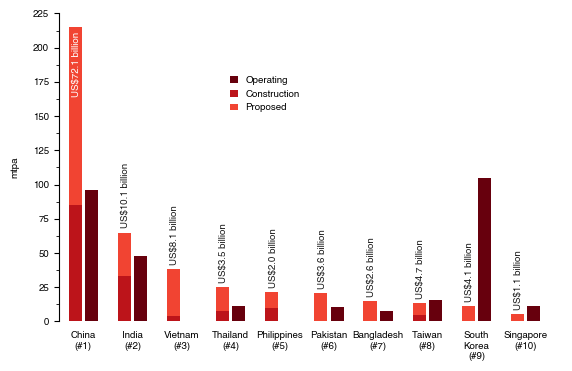

In [135]:
font_size=7
spread_out=3
ytop1 = 225
set_width=0.8

n_countries = 10
use_this_df = mtpa_by_country_import_df.copy().loc[mtpa_by_country_import_df.index.isin(
    region_dict_df.loc[region_dict_df.AsiaGasTracker=='Yes']['Country'].tolist())
                                                  ].sort_values('Proposed+Construction', ascending=True)[-n_countries:][::-1]

yaxis_labels = [use_this_df.index.tolist()[i] + ' (#'+str(i+1)+')' for i in range(n_countries)]
yaxis_labels = [textwrap.fill(i, 5, break_long_words=False) for i in yaxis_labels] # wrap beyond 10 characters

use_this_df_costs = cost_by_country_import_df.copy()/1e9
capex_text = ['US$'+str('{0:.1f}'.format(use_this_df_costs.loc[i]['Proposed+Construction']))+' billion' 
              for i in use_this_df.index]

fig = mp.figure(figsize=(6.5,4))#, constrained_layout=True)
widths = [1]
heights = [1]
gs = matplotlib.gridspec.GridSpec(nrows=1, ncols=1, figure=fig,
                                 wspace=0., hspace=0,
                                 width_ratios=widths,
                                 height_ratios=heights)

# proposed+construction
ax1 = fig.add_subplot(gs[0,0])

ax1.bar(height=use_this_df['Operating'],
         x=numpy.arange(n_countries)*spread_out+1,
         color=tracker_operating,
         label='Operating',
         width=set_width)

ax1.bar(height=use_this_df['Construction'],
         x=numpy.arange(n_countries)*spread_out,
         color=tracker_construction,
         label='Construction',
         width=set_width)

ax1.bar(height=use_this_df['Proposed'],
         x=numpy.arange(n_countries)*spread_out,
         bottom=use_this_df['Construction'],
         color=tracker_proposed,
         label='Proposed',
         width=set_width)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
#ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(labelsize=font_size,
               bottom=False)
#ax1.xaxis.set_ticks([])
ax1.set_ylim(0, ytop1)
ax1.set_xlim(-1,use_this_df.index.size*spread_out-0.25)

ax1.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

for i in range(n_countries):
    if use_this_df.index[i]=='China':
        ax1.text(s=capex_text[i],
                 y=use_this_df[['Proposed','Construction']].sum(axis=1).values[i]-3,
                 x=(numpy.arange(n_countries)*spread_out)[i]+0.1*set_width,
                 fontsize=font_size,
                 color='1', rotation=90,
                 ha='center', va='top')
    else:
        ax1.text(s=capex_text[i],
                 y=use_this_df[['Proposed','Construction']].sum(axis=1).values[i]+3,
                 x=(numpy.arange(n_countries)*spread_out)[i]+0.1*set_width,
                 fontsize=font_size,
                 color='0.1', rotation=90,
                 ha='center', va='bottom')

ax1.xaxis.set_ticks(numpy.arange(n_countries)*spread_out+0.5)
ax1.xaxis.set_ticklabels(yaxis_labels, ha='center', va='top')

# combine legends
ax1_h,ax1_l = ax1.get_legend_handles_labels()
ax1.legend(ax1_h, ax1_l, 
           fontsize=font_size, frameon=False, handlelength=0.75, loc=(0.333,0.666))

ax1.set_ylabel('mtpa', size=font_size, labelpad=10)

#ax1.xaxis.grid()
#fig.tight_layout()

mp.savefig('saved-figures/panel-bar-plots-top10-with-costs-grouped-bars-flipped.png', bbox_inches='tight', 
           dpi=600, transparent=True)
mp.savefig('saved-figures/panel-bar-plots-top10-with-costs-grouped-bars-flipped.svg', bbox_inches='tight', 
           transparent=True)
mp.savefig('saved-figures/panel-bar-plots-top10-with-costs-grouped-bars-flipped.pdf', bbox_inches='tight', 
           transparent=True)


## appendix tables

### imports

In [136]:
countries_touse = sorted(region_dict_df.loc[region_dict_df.AsiaGasTracker=='Yes']['Country'].tolist()+['Guam','Papua New Guinea','Chinese Taipei'])

temp_df = mtpa_by_country_import_df.loc[
    mtpa_by_country_import_df.index.isin(
    countries_touse)
    ].reindex(countries_touse).sort_index()

# total
if 'Total' in temp_df.index:
    temp_df.drop(index='Total', inplace=True)   
    total = temp_df.sum(axis=0, min_count=0)
    total.name='Total'
    temp_df = temp_df.append(total)

else:
    total = temp_df.sum(axis=0, min_count=0)
    total.name='Total'
    temp_df = temp_df.append(total)
    
region_column = region_dict_df.set_index('Country').loc[countries_touse]['Region']
temp_df.insert(0,'Region',region_column)
temp_df.replace(numpy.nan,'').replace(0,'')

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_65544/630791172.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(total)


,Region,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Bangladesh,South Asia,15.05,,15.05,,26.25,7.3,,,
Bhutan,South Asia,,,,,,,,,
Brunei,SE Asia,,,,,,,,,
Cambodia,SE Asia,3.6,,3.6,,,,,,
China,East Asia,129.66,85.25,214.91,25.8,45.92,96.31,,,
Chinese Taipei,East Asia,,,,,,,,,
Guam,SE Asia,,,,,,,,,
Hong Kong,East Asia,,1.2,1.2,,,,,,
India,South Asia,32.0,33.0,65.0,5.0,46.7,47.5,,,
Indonesia,SE Asia,4.34,0.4,4.74,1.4,15.21,14.85,,,


### exports capacity

In [137]:
countries_touse = sorted(region_dict_df.loc[region_dict_df.AsiaGasTracker=='Yes']['Country'].tolist()+['Guam','Papua New Guinea','Chinese Taipei'])

temp_df = mtpa_by_country_export_df.loc[
    mtpa_by_country_export_df.index.isin(
    countries_touse)
    ].reindex(countries_touse).sort_index()

# total
if 'Total' in temp_df.index:
    temp_df.drop(index='Total', inplace=True)   
    total = temp_df.sum(axis=0, min_count=0)
    total.name='Total'
    temp_df = temp_df.append(total)

else:
    total = temp_df.sum(axis=0, min_count=0)
    total.name='Total'
    temp_df = temp_df.append(total)
    
region_column = region_dict_df.set_index('Country').loc[countries_touse]['Region']
temp_df.insert(0,'Region',region_column)
temp_df.replace(numpy.nan,'').replace(0,'')

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_65544/2480571858.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(total)


,Region,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Bangladesh,South Asia,,,,,,,,,
Bhutan,South Asia,,,,,,,,,
Brunei,SE Asia,,,,,,7.4,,,
Cambodia,SE Asia,,,,,,,,,
China,East Asia,,,,,,,,,
Chinese Taipei,East Asia,,,,,,,,,
Guam,SE Asia,,,,,,,,,
Hong Kong,East Asia,,,,,,,,,
India,South Asia,,,,,,,,,
Indonesia,SE Asia,9.5,5.8,15.3,,2.95,19.45,,,30.1


### import capex

In [138]:
countries_touse = sorted(region_dict_df.loc[region_dict_df.AsiaGasTracker=='Yes']['Country'].tolist()+['Guam','Papua New Guinea','Chinese Taipei'])

temp_df = cost_by_country_import_df.loc[
    cost_by_country_import_df.index.isin(
    countries_touse)
    ].reindex(countries_touse).sort_index()/1e9

# total
if 'Total' in temp_df.index:
    temp_df.drop(index='Total', inplace=True)   
    total = temp_df.sum(axis=0, min_count=0)
    total.name='Total'
    temp_df = temp_df.append(total)

else:
    total = temp_df.sum(axis=0, min_count=0)
    total.name='Total'
    temp_df = temp_df.append(total)
    
region_column = region_dict_df.set_index('Country').loc[countries_touse]['Region']
temp_df.insert(0,'Region',region_column)
temp_df.replace(numpy.nan,'').replace(0,'')

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_65544/3319260761.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(total)


,Region,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Bangladesh,South Asia,2.615819,,2.615819,,4.103159,0.661267,,,
Bhutan,South Asia,,,,,,,,,
Brunei,SE Asia,,,,,,,,,
Cambodia,SE Asia,0.697399,,0.697399,,,,,,
China,East Asia,42.931215,29.186591,72.117807,7.144935,15.50527,35.100795,,,
Chinese Taipei,East Asia,,,,,,,,,
Guam,SE Asia,,,,,,,,,
Hong Kong,East Asia,,0.421966,0.421966,,,,,,
India,South Asia,4.406323,5.719267,10.12559,0.830943,8.242219,10.221449,,,
Indonesia,SE Asia,1.568979,0.081975,1.650954,0.192707,2.901093,2.27231,,,


### export capex

In [139]:
countries_touse = sorted(region_dict_df.loc[region_dict_df.AsiaGasTracker=='Yes']['Country'].tolist()+['Guam','Papua New Guinea','Chinese Taipei'])

temp_df = cost_by_country_export_df.loc[
    cost_by_country_export_df.index.isin(
    countries_touse)
    ].reindex(countries_touse).sort_index()/1e9

# total
if 'Total' in temp_df.index:
    temp_df.drop(index='Total', inplace=True)   
    total = temp_df.sum(axis=0, min_count=0)
    total.name='Total'
    temp_df = temp_df.append(total)

else:
    total = temp_df.sum(axis=0, min_count=0)
    total.name='Total'
    temp_df = temp_df.append(total)

region_column = region_dict_df.set_index('Country').loc[countries_touse]['Region']
temp_df.insert(0,'Region',region_column)
temp_df.replace(numpy.nan,'').replace(0,'')

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_65544/3232733097.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(total)


,Region,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
Bangladesh,South Asia,,,,,,,,,
Bhutan,South Asia,,,,,,,,,
Brunei,SE Asia,,,,,,4.360211,,,
Cambodia,SE Asia,,,,,,,,,
China,East Asia,,,,,,,,,
Chinese Taipei,East Asia,,,,,,,,,
Guam,SE Asia,,,,,,,,,
Hong Kong,East Asia,,,,,,,,,
India,South Asia,,,,,,,,,
Indonesia,SE Asia,20.0,2.378435,22.378435,,1.738192,13.703795,,,17.735453
